In [1]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import os
os.chdir("/workspace/lambda-diffusers")
!pip install -r requirements.txt
!pip install accelerate
!pip install --upgrade diffusers
!pip install umap
!pip install fastparquet
!pip install spkit

!pip install --upgrade torchtext
!pip install pytorch-lightning==1.8.3.post0

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
Obtaining file:///workspace/lambda-diffusers (from -r requirements.txt (line 9))
  Preparing metadata (setup.py) ... done
  Using cached transformers-4.22.1-py3-none-any.whl (4.9 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached Pillow-9.2.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached diffusers-0.3.0-py3-none-any.whl (153 kB)
  Using cached onnxruntime-1.12.1-cp310-cp310-manylinux_2_27_x86_64.whl (4.9 MB)
  Using cached scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1


In [3]:
!pip install mxnet-cu112

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/499.4 MB 19.9 MB/s eta 0:00:25ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/499.4 MB 18.1 MB/s eta 0:00:27

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 40.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.6 MB ? eta -:--:--ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

     ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 1.0/1.6 MB 44.6 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import os
import sys
import torch
from typing import Tuple, Union
from mxnet import nd, symbol
from mxnet.gluon.nn import HybridBlock
from mxnet.gluon.parameter import Parameter
from mxnet.initializer import Zero
from mxnet.gluon.nn import Conv2D, HybridSequential, LeakyReLU, Dense
from mxnet import nd, gluon, autograd
import mxnet as mx
from mxnet.io import NDArrayIter
import typing

: 

: 

In [40]:
from transformers import CLIPFeatureExtractor, CLIPModel
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.linear_model import Ridge
import pickle
import pandas as pd
from mxnet import nd
from mxnet.io import NDArrayIter
from mxnet.symbol import Symbol
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

sys.path.append("/workspace/lambda-diffusers/lambda_diffusers")

In [5]:
torch.cuda.device_count()

1

In [6]:
 print(torch.version.cuda)

11.7


In [7]:
os.chdir("/workspace/lambda-diffusers/lambda_diffusers/pipelines")


In [8]:
from pipelines.pipeline_stable_diffusion_im_embed import CLIPImageEncoder
from PIL import Image

In [9]:
def load_dataset(t, x, batch_size):
    return NDArrayIter({ "x": nd.stack(*x, axis=0) }, { "t": nd.stack(*t, axis=0) }, batch_size, True)

In [10]:
subject = 1
batch_size = 30

with open("/workspace/hyper/data_%i.dat" % subject, 'rb') as f:
          X_tr, T_tr, X_te, T_te = pickle.load(f)
          train = load_dataset(nd.array(T_tr), nd.array(X_tr), batch_size)        
          test =  load_dataset(nd.array(T_te), nd.array(X_te), batch_size=36)  

In [11]:
class Linear(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units=n_in))


class Pixelnorm(HybridBlock):
    def __init__(self, epsilon: float = 1e-8) -> None:
        super(Pixelnorm, self).__init__()
        self.epsilon = epsilon

    def hybrid_forward(self, F, x) -> nd:
        return x * F.rsqrt(F.mean(F.square(x), 1, True) + self.epsilon)


class Bias(HybridBlock):
    def __init__(self, shape: Tuple) -> None:
        super(Bias, self).__init__()
        self.shape = shape
        with self.name_scope():
            self.b = self.params.get("b", init=Zero(), shape=shape)

    def hybrid_forward(self, F, x, b) -> nd:
        return F.broadcast_add(x, b[None, :, None, None])


class Block(HybridSequential):
    def __init__(self, channels: int, in_channels: int) -> None:
        super(Block, self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        with self.name_scope():
            self.add(Conv2D(channels, 3, padding=1, in_channels=in_channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(channels, 3, padding=1, in_channels=channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())

    def hybrid_forward(self, F, x) -> nd:
        x = F.repeat(x, 2, 2)
        x = F.repeat(x, 2, 3)
        for i in range(len(self)):
            x = self[i](x)
        return x


In [12]:

class Generator(HybridSequential):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        with self.name_scope():
            self.add(Pixelnorm())
            self.add(Dense(8192, use_bias=False, in_units=512))
            self.add(Bias((512,)))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(512, 3, padding=1, in_channels=512))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            
            self.add(Block(512, 512)) # 8
            self.add(Block(512, 512))
            self.add(Block(512, 512))
            self.add(Block(256, 512))
            self.add(Block(128, 256))
            self.add(Block(64, 128))
            self.add(Block(32, 64))
            self.add(Block(16, 32)) # 15
            self.add(Conv2D(3, 1, in_channels=16))

    
    def hybrid_forward(self, F: Union[nd.NDArray, Symbol], x: nd, layer: int) -> nd:
        x = F.Reshape(self[1](self[0](x)), (-1, 512, 4, 4))
        for i in range(2, len(self)):
            x = self[i](x)
            if i == layer + 7:
              return x
        return x

In [13]:
generator = Generator()
generator.load_parameters("/workspace/hyper/generator.params")

In [14]:
face = generator(train.label[0][1][47][None], 9).asnumpy()

In [15]:
train.label[0][1].shape

(1050, 512)

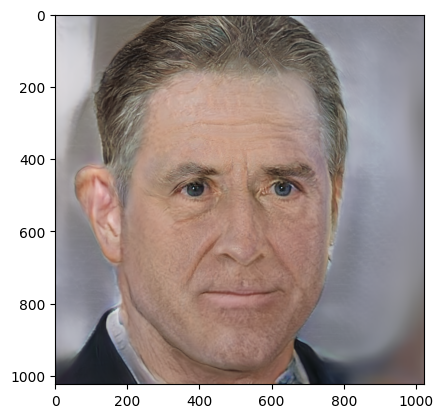

In [16]:
face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
face = face.astype("uint8")
face = face.transpose(0, 2, 3, 1)
face = Image.fromarray(face[0], 'RGB')
plt.imshow(face)

In [17]:
face.save("/workspace/outputs/img1.jpg")

In [19]:
def createCLIPLatents(hyper_latents):
    
    sd_pipe = CLIPImageEncoder(CLIPModel, CLIPFeatureExtractor)
    
    latents = []
    
    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
            ),
        transforms.Normalize(
        [0.48145466, 0.4578275, 0.40821073],
        [0.26862954, 0.26130258, 0.27577711]),
        transforms.ToPILImage()
    ])
        
    
    
    for hyper_latent in hyper_latents[0][1]:
        
        face = generator(hyper_latent[None], 9).asnumpy()
        
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        face = Image.fromarray(face[0], 'RGB')
        
        face = tform(face)
        
        clip_latent = sd_pipe(inp)
      
        latents.append([hyper_latent, clip_latent])
        
        
    return latents
        
        
        
    

In [20]:
latents = createCLIPLatents(train.label)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [22]:
latents_array = np.array(latents)

/tmp/ipykernel_7318/4060342655.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  latents_array = np.array(latents)
/tmp/ipykernel_7318/4060342655.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  latents_array = np.array(latents)


In [38]:
brain_data = train.data[0][1]

In [43]:
reg = LinearRegression().fit(brain_data, latents_array[:,1])



: 

: 

In [41]:
predicted_clip_latents = reg.predict(x_te)

(1050, 2)

In [ ]:
reg